# gyrochronology fitting using gyro-interp
* https://gyro-interp.readthedocs.io/en/latest/examples.html

gyro-interp needs rotation period and Teff of the star to estimate its age. 

Using `Target.query_vizier_param()`, I compiled useful parameters into a table.

In [1]:
import sys

# make sure you are using `gyrointerp` environment
assert sys.executable.split('/')[5]=='gyrointerp'

In [2]:
# Inside this jupyter lab, do not use `pip install xxx`, instead use:
# import sys
# !{sys.executable} -m pip install xxx

In [3]:
# check if package is installed
!{sys.executable} -m pip show gyrointerp

Name: gyrointerp
Version: 0.5
Summary: Gyrochronology via interpolation of open cluster rotation sequences.
Home-page: https://github.com/lgbouma/gyro-interp
Author: Luke Bouma
Author-email: bouma.luke@gmail.com
License: MIT
Location: /mnt_ut3/raid_ut3/home/jerome/github/research/project/ext_tools/gyro-interp
Editable project location: /mnt_ut3/raid_ut3/home/jerome/github/research/project/ext_tools/gyro-interp
Requires: astropy, matplotlib, numpy, pandas, scipy
Required-by: 


## Bouma+2024b data

In [4]:
from astropy.io import ascii

url = "https://content.cld.iop.org/journals/0004-637X/976/2/234/revision1/apjad855ft1_mrt.txt"
tab = ascii.read(url)
tab[:3]

KIC,KOI,Kepler,Disp,Teff,e_Teff,r_Teff,Prot,e_Prot,r_Prot,EW,e_EW,tGyro,E_tGyro,e_tGyro,2Up-tGyro,2Lo-tGyro,tLi,E_tLi,e_tLi,Rp,r_Rp,Per,StarFlag,PlanetFlag,HiRes,Consist,f_tGyro,f_tLi
,,,,K,K,,d,d,,1e-13 m,1e-13 m,Myr,Myr,Myr,Myr,Myr,1e-13 m,1e-13 m,1e-13 m,Rgeo,,d,,,,,,
int64,str9,str14,str9,int64,int64,str19,str5,str5,str19,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,str19,float64,int64,int64,int64,str5,str6,str5
6184894,K05245.01,Kepler-1627 b,CONFIRMED,5357,95,2020AJ....159..280B,2.620,0.026,2021ApJS..255...17S,225,7,81,158,55,413,77,51,38,27,3.79,2022AJ....163..121B,7.2,2176,0,1,Yes,--,--
10736489,K07368.01,Kepler-1974 b,CONFIRMED,5068,76,2020AJ....159..280B,2.560,0.026,2021ApJS..255...17S,248,4,88,183,60,420,84,54,47,25,2.22,2022AJ....164..215B,6.84,2560,0,1,Yes,--,--
10717220,K06228.01,Kepler-1644 b,CONFIRMED,5521,109,2020AJ....159..280B,1.430,0.014,2021ApJS..255...17S,-2,13,77,144,53,409,74,--,--,--,1.88,10.26133/NEA4,21.09,2690,4,1,No,--,> 767


In [5]:
df = tab.to_pandas()
df.shape

(2461, 29)

In [6]:
df.head()

,KIC,KOI,Kepler,Disp,Teff,e_Teff,r_Teff,Prot,e_Prot,r_Prot,...,e_tLi,Rp,r_Rp,Per,StarFlag,PlanetFlag,HiRes,Consist,f_tGyro,f_tLi
0,6184894,K05245.01,Kepler-1627 b,CONFIRMED,5357,95,2020AJ....159..280B,2.620,0.026,2021ApJS..255...17S,...,27,3.79,2022AJ....163..121B,7.20,2176,0,1,Yes,NaN,NaN
1,10736489,K07368.01,Kepler-1974 b,CONFIRMED,5068,76,2020AJ....159..280B,2.560,0.026,2021ApJS..255...17S,...,25,2.22,2022AJ....164..215B,6.84,2560,0,1,Yes,NaN,NaN
2,10717220,K06228.01,Kepler-1644 b,CONFIRMED,5521,109,2020AJ....159..280B,1.430,0.014,2021ApJS..255...17S,...,<NA>,1.88,10.26133/NEA4,21.09,2690,4,1,No,NaN,> 767
3,8653134,K06186.01,Kepler-1643 b,CONFIRMED,4918,83,2020AJ....159..280B,5.05,0.05,SantosPrivComm,...,76,2.11,2022AJ....163..179P,5.34,0,0,1,Yes,NaN,NaN
4,11244682,K03933.01,Kepler-1699 b,CONFIRMED,5496,163,2021ApJS..255...17S,4.160,0.042,2021ApJS..255...17S,...,<NA>,1.32,10.26133/NEA4,3.49,2688,0,1,No,NaN,> 889


In [7]:
cols = ['Prot','Teff','e_Prot','e_Teff', 'tGyro','E_tGyro','e_tGyro']
df[cols] = df[cols].astype(float)

## setup and run gyro-interp

In [8]:
# name = "Kepler-1627 b" # age<0.1Gy
name = 'Kepler-447 b' # 0.1<age<1Gy
d = df.query("Kepler==@name").squeeze()
d

KIC                      11017901
KOI                     K01800.01
Kepler               Kepler-447 b
Disp                    CONFIRMED
Teff                       5648.0
e_Teff                       89.0
r_Teff        2020AJ....159..280B
Prot                          6.4
e_Prot                       0.06
r_Prot        2021ApJS..255...17S
EW                            103
e_EW                            3
tGyro                       420.0
E_tGyro                      64.0
e_tGyro                      78.0
2Up-tGyro                     128
2Lo-tGyro                     202
tLi                           405
E_tLi                         355
e_tLi                         203
Rp                           18.5
r_Rp          2022AJ....163..179P
Per                          7.79
StarFlag                     2048
PlanetFlag                      4
HiRes                           1
Consist                       Yes
f_tGyro                       NaN
f_tLi                         NaN
Name: 33, dtyp

`interp_method='pchip_m67'`: Piecewise Cubic Hermite Interpolating Polynomials (PCHIP) to interpolate over not only 0.08-2.6 Gyr, but also sets the gradient in Prot vs Time in the 1-2.6 Gyr interval based on the observations of M67 from `Barnes+20163

`bounds_error='4gyrlimit'`: "nan", "limit", "4gyrlimit", and "4gyrextrap". Default
            "4gyrlimit" behavior at the old end is to not extrapolate at all, which
            means that this choice yields biased uncertainties at >~3.5 Gyr.
            If "4gyrextrap" is instead used, this will extrapolate by returning
            the rotation period linearly extrapolated from the Prot vs time
            slope at any temperature at 4 Gyr.  At the young end, the ansatz
            for both methods is that the period does not change.  In detail,
            this is physically wrong; the posterior in this regime is formally
            an age upper limit.  Finally, if "nan", ages above or below the
            minimum reference age return NaNs.


In [9]:
Prot = d.Prot
Teff = d.Teff
Prot_err = d.e_Prot
Teff_err = d.e_Teff

In [10]:
Prot, Prot_err, Teff, Teff_err

(np.float64(6.4), np.float64(0.06), np.float64(5648.0), np.float64(89.0))

In [11]:
import numpy as np
from gyrointerp import gyro_age_posterior
from gyrointerp import get_summary_statistics

# typically, Prot<17 has age < 1 Gy
# uniformly spaced grid between 0 and 2600 megayears
age_grid = np.linspace(0, 2600, 500)

# calculate the age posterior - takes ~30 seconds
age_posterior = gyro_age_posterior(Prot, 
                                   Teff, 
                                   Prot_err=Prot_err, 
                                   Teff_err=Teff_err, 
                                   age_grid=age_grid,
                                   bounds_error='4gyrlimit',
                                   interp_method='pchip_m67'
)

# calculate dictionary of summary statistics
result = get_summary_statistics(age_grid, age_posterior)
print(f"Age = {result['median']} +{result['+1sigma']} -{result['-1sigma']} Myr.")

Age = 420.21 +64.08 -77.92 Myr.


In [12]:
# import custom code from the `code` directory
import sys
sys.path.insert(0, '../code')

from kenmon import plot_age_posterior

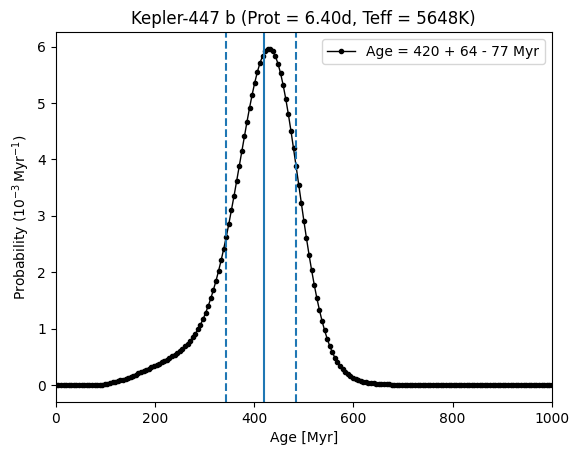

In [13]:
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

# fp = name.replace(' ','')+'_age_gyro.png'
# fig.savefig(fp, bbox_inches='tight')

In [14]:
#compare with published results
print(f"age of {name} = {d['tGyro']}-{d['e_tGyro']}+{d['E_tGyro']} Myr")

age of Kepler-447 b = 420.0-78.0+64.0 Myr


## impact of changing age grid

In [15]:
# wider than default grid
age_grid = np.linspace(0, 4000, 500)

age_posterior = gyro_age_posterior(Prot, 
                                   Teff, 
                                   Prot_err=Prot_err, 
                                   Teff_err=Teff_err, 
                                   age_grid=age_grid,
                                   bounds_error='4gyrlimit',
                                   interp_method='pchip_m67'
)

# calculate dictionary of summary statistics
result = get_summary_statistics(age_grid, age_posterior)
print(f"Age = {result['median']} +{result['+1sigma']} -{result['-1sigma']} Myr.")

Age = 420.19 +64.26 -78.01 Myr.


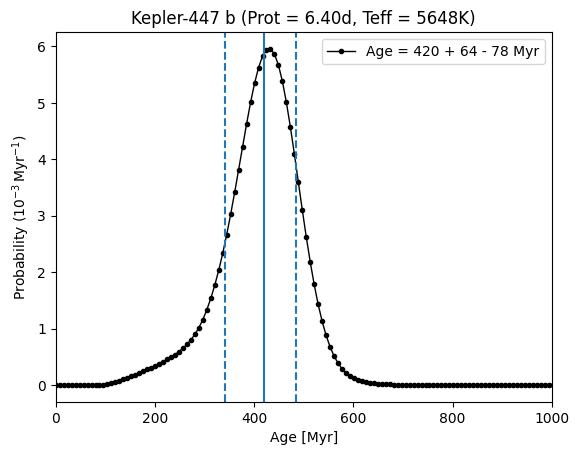

In [16]:
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

# fp = name.replace(' ','')+'_age_gyro.png'
# fig.savefig(fp, bbox_inches='tight')

> Basically identical results.

In [17]:
# widest grid beyond m67 age
age_grid = np.linspace(0, 5000, 500)

age_posterior = gyro_age_posterior(Prot, 
                                   Teff, 
                                   Prot_err=Prot_err, 
                                   Teff_err=Teff_err, 
                                   age_grid=age_grid,
                                   bounds_error='4gyrextrap',
)

# calculate dictionary of summary statistics
result = get_summary_statistics(age_grid, age_posterior)
print(f"Age = {result['median']} +{result['+1sigma']} -{result['-1sigma']} Myr.")

Age = 420.19 +64.37 -78.06 Myr.


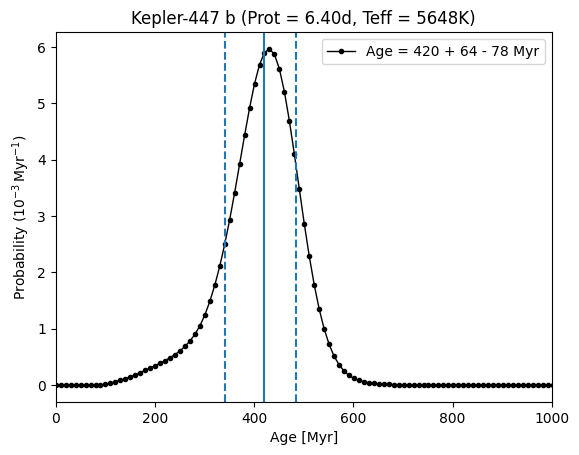

In [18]:
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

# fp = name.replace(' ','')+'_age_gyro.png'
# fig.savefig(fp, bbox_inches='tight')

> Again identical results.

## Summary

To avoid results biased towards younger ages, use a wide `age_grid` up to 5Gy and use `bounds_error='4gyrextrap'`:
```
age_grid = np.linspace(0, 4000, 500)
age_posterior = gyro_age_posterior(Prot, 
                                   Teff, 
                                   Prot_err=Prot_err, 
                                   Teff_err=Teff_err, 
                                   age_grid=age_grid,
                                   bounds_error='4gyrextrap',
)
```

## Exercise
* Run gyro-interp in all TOI and known host stars in NExSci (see `youth_indicators_nexsci.csv`) 
* Update the TOI and nexsci tables using data from previous research

Hint: see [documentation](https://gyro-interp.readthedocs.io/en/latest/examples.html#ages-for-many-stars)